# Example of using PySpark to do data analysis with dataframe

## Imports and variables

In [1]:
from pyspark import SparkConf, SparkContext                    
from mmtfPyspark.io import mmtfReader                                
from mmtfPyspark.webfilters import Pisces                        
from mmtfPyspark.datasets import groupInteractionExtractor
from mmtfPyspark.structureViewer import view_group_interaction
import matplotlib.pyplot as plt
import pandas as pd
import py3Dmol
import time
                                                               
# Create variables                                             
APP_NAME = "MMTF_Spark"                                        
path = "./resources/mmtf_full_sample/"                            

# Configure Spark                                              
conf = SparkConf().setAppName(APP_NAME).setMaster("local[*]")  
sc = SparkContext(conf=conf)                                   

## Read PDB and create PISCES non-redundant set

In [2]:
pdb = mmtfReader.read_sequence_file(path, sc)
pdb = pdb.filter(Pisces(sequenceIdentity = 20, resolution = 2.0))         

## Extract Zinc interactions

In [3]:
finder = groupInteractionExtractor("ZN", distance = 3.0)       
interactions = finder.get_dataset(pdb)

interactions.show(10)

+-----------+--------+-----+--------+------+--------+-----+--------+------+---------+
|structureId|residue1|atom1|element1|index1|residue2|atom2|element2|index2| distance|
+-----------+--------+-----+--------+------+--------+-----+--------+------+---------+
|       1FN9|      ZN|   ZN|      Zn|   730|     CYS|   SG|       S|    50|2.3709755|
|       1FN9|      ZN|   ZN|      Zn|   730|     CYS|   SG|       S|    53|2.3940797|
|       1FN9|      ZN|   ZN|      Zn|   730|     HIS|  NE2|       N|    70|2.2196307|
|       1FN9|      ZN|   ZN|      Zn|   730|     CYS|   SG|       S|    72|2.3465357|
|       1FN9|      ZN|   ZN|      Zn|   731|     CYS|   SG|       S|   415|2.3747551|
|       1FN9|      ZN|   ZN|      Zn|   731|     CYS|   SG|       S|   418|2.3680198|
|       1FN9|      ZN|   ZN|      Zn|   731|     HIS|  NE2|       N|   435|2.1647959|
|       1FN9|      ZN|   ZN|      Zn|   731|     CYS|   SG|       S|   437|2.3763454|
|       1A73|      ZN|   ZN|      Zn|   366|     CYS| 

## Get unique PDBIds from result

In [4]:
# Get list of PDBids
pdbIds = [row.structureId for row in interactions.collect()]

# Get unique pdbIds and convert back to list
unique_pdbIds = list(set(pdbIds))

## Visualize first hit

In [5]:
view_group_interaction(unique_pdbIds, 'ZN', style='cartoon')

interactive(children=(IntSlider(value=0, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<function mmtfPyspark.structureViewer.view_group_interaction.<locals>.view3d(i=0)>

## Show top 10 interacting groups                           


In [6]:
df = interactions.filter("element2 != 'C'")\
                 .groupBy("residue2")\
                 .count()\
                 .sort("count", ascending=False)\
                 .toPandas()
df.head(10)

,residue2,count
0,CYS,19
1,HIS,14
2,HOH,10
3,GLU,5
4,ASP,5
5,VAL,2
6,TRP,2
7,CL,1


## Plot histogram for top 10 interacting groups

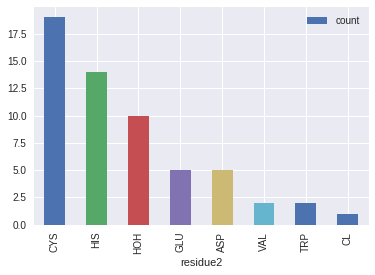

In [7]:
df.head(10).plot(x='residue2', y='count', kind='bar')

In [8]:
sc.stop()